In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [6]:
df = pd.read_csv("../data/data_incl_next_3_gws.csv", low_memory=False)

In [9]:
print(list(df.columns))

['gw', 'year', 'player', 'n_games_in_gw', 'points_scored', 'avg_home', 'playing_against_mean_difficulty', 'playing_against_mean_defence', 'playing_against_mean_attack', 'playing_for_difficulty', 'playing_for_defence', 'playing_for_attack', 'form', 'position', 'creativity', 'influence', 'threat', 'selected', 'playing_chance', 'birth_date', 'corners_and_free_kicks_order', 'penalties_order', 'avg_minutes_when_playing', 'avg_points_when_playing', 'avg_yellows_p_game_when_playing', 'avg_reds_p_game_when_playing', 'avg_bps_p_game_when_playing', 'avg_goals_p_game_when_playing', 'avg_assists_p_game_when_playing', 'avg_clean_sheets_when_playing', 'avg_goals_conceded_when_playing', 'avg_starts_when_playing', 'avg_saves_when_playing', 'next3_n_gws', 'target_next3_mean_points', 'next3_sum__n_games_in_gw', 'next3_mean__avg_home', 'next3_mean__playing_against_mean_difficulty', 'next3_mean__playing_against_mean_defence', 'next3_mean__playing_against_mean_attack', 'next3_mean__playing_for_difficulty',

In [3]:
X_COLS = [
    # prior-only form/rates
    "form",
    "avg_minutes_when_playing", "avg_points_when_playing",
    "avg_yellows_p_game_when_playing", "avg_reds_p_game_when_playing",
    "avg_bps_p_game_when_playing", "avg_goals_p_game_when_playing",
    "avg_assists_p_game_when_playing", "avg_clean_sheets_when_playing",
    "avg_goals_conceded_when_playing", "avg_starts_when_playing", "avg_saves_when_playing",

    # player/meta (time-appropriate snapshots)
    "position", "creativity", "influence", "threat",
    "selected", "playing_chance",
    "corners_and_free_kicks_order", "penalties_order",

    # future schedule over t..t+2 (OK to use)
    "next3_sum__n_games_in_gw",
    "next3_mean__avg_home",
    "next3_mean__playing_against_mean_difficulty",
    "next3_mean__playing_against_mean_defence",
    "next3_mean__playing_against_mean_attack",
    "next3_mean__playing_for_difficulty",
    "next3_mean__playing_for_defence",
    "next3_mean__playing_for_attack",
]

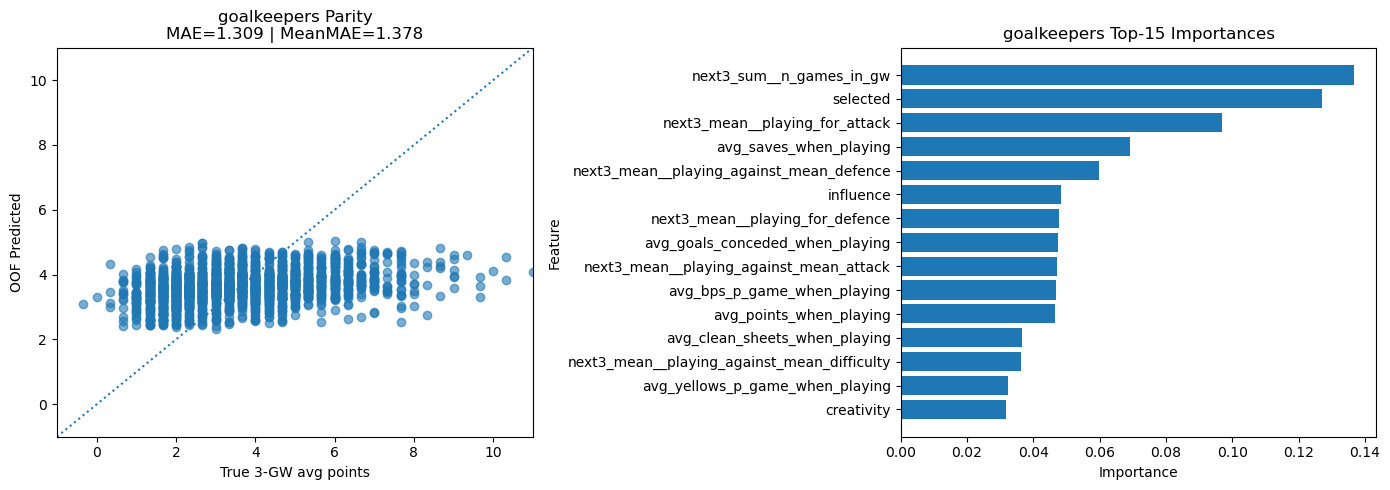

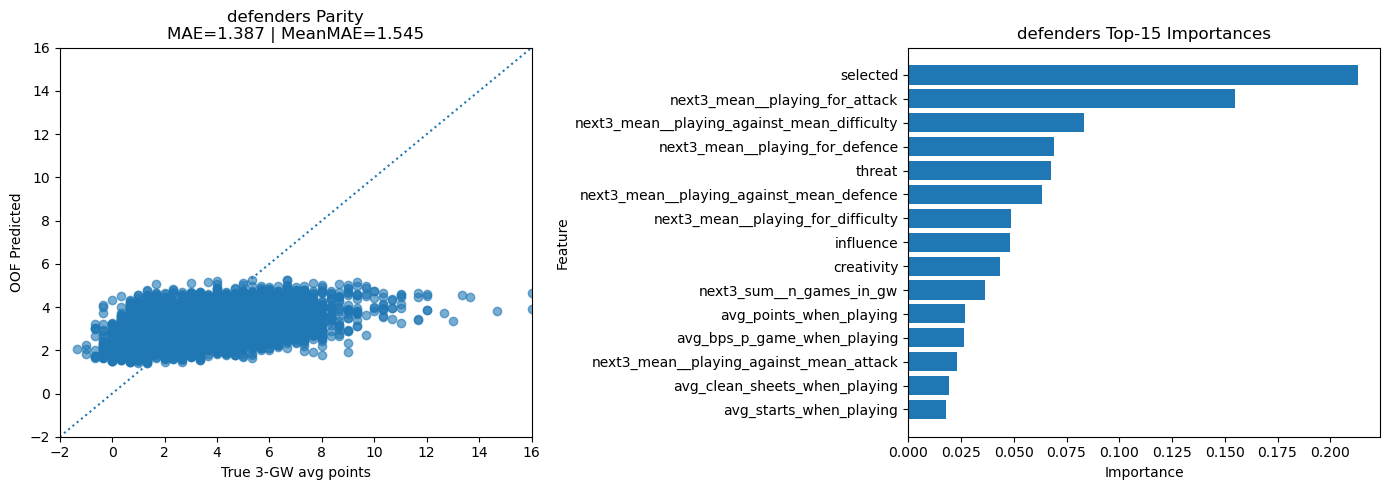

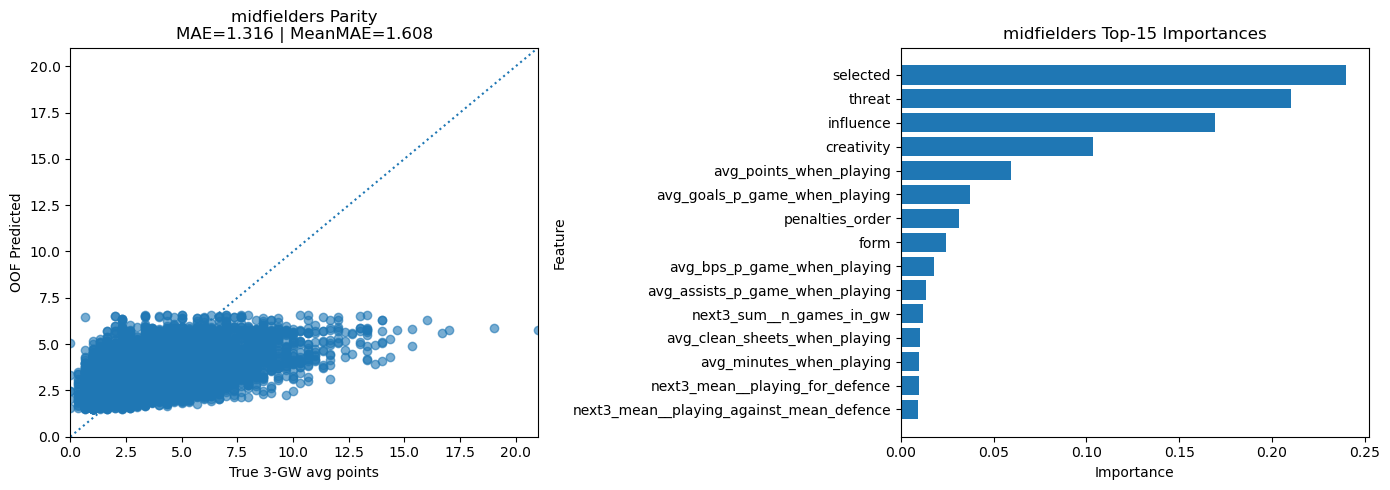

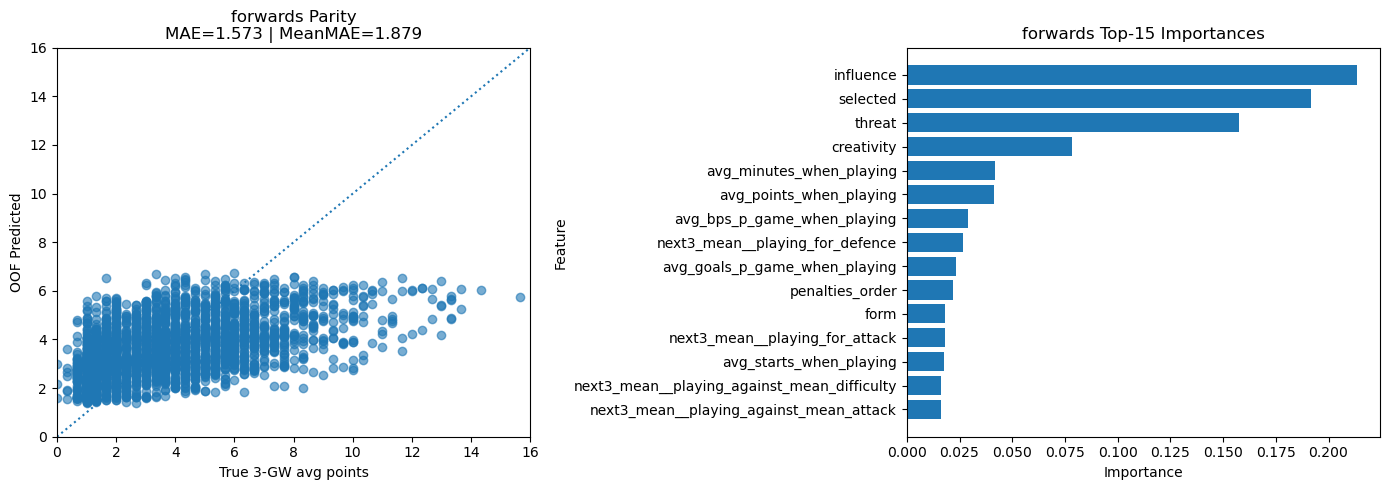

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

# ---- config ----
TARGET = "target_next3_mean_points"
TOPK = 15
pos_map = {1: "goalkeepers", 2: "defenders", 3: "midfielders", 4: "forwards"}

# your agreed feature list (intersection with df columns is used)
X_COLS = [
    # prior-only form/rates
    "form",
    "avg_minutes_when_playing", "avg_points_when_playing",
    "avg_yellows_p_game_when_playing", "avg_reds_p_game_when_playing",
    "avg_bps_p_game_when_playing", "avg_goals_p_game_when_playing",
    "avg_assists_p_game_when_playing", "avg_clean_sheets_when_playing",
    "avg_goals_conceded_when_playing", "avg_starts_when_playing", "avg_saves_when_playing",

    # player/meta (pre-GW snapshots)
    "position", "creativity", "influence", "threat",
    "selected", "playing_chance",
    "corners_and_free_kicks_order", "penalties_order",

    # future schedule over t..t+2 (known pre-window)
    "next3_sum__n_games_in_gw",
    "next3_mean__avg_home",
    "next3_mean__playing_against_mean_difficulty",
    "next3_mean__playing_against_mean_defence",
    "next3_mean__playing_against_mean_attack",
    "next3_mean__playing_for_difficulty",
    "next3_mean__playing_for_defence",
    "next3_mean__playing_for_attack",
]

def plot_parity_and_importances_for_position(df, pos_id):
    d = df[df["position"] == pos_id].copy()
    if d.empty:
        print(f"[{pos_map[pos_id]}] no rows, skipping.")
        return None

    # Build X safely
    cols = [c for c in X_COLS if c in d.columns]
    if "position" in cols:  # per-position model -> drop constant feature
        cols.remove("position")

    X = d[cols]
    y = d[TARGET].astype(float)
    groups = d["player"]

    # Conservative RF to reduce overfitting
    min_leaf = max(20, int(0.01 * len(d)))  # ~1% of samples, at least 20
    rf = RandomForestRegressor(
        n_estimators=800,
        max_depth=12,
        min_samples_leaf=min_leaf,
        max_features="sqrt",
        bootstrap=True,
        max_samples=0.8,
        random_state=42,
        n_jobs=-1,
        oob_score=True,
    )

    pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("rf", rf),
    ])

    # Group-aware OOF predictions
    n_players = d["player"].nunique()
    n_splits = 5 if n_players >= 5 else max(2, n_players)
    gkf = GroupKFold(n_splits=n_splits)

    y_pred_oof = cross_val_predict(
        pipe, X, y, cv=gkf, groups=groups, method="predict", n_jobs=-1
    )
    base_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("mean", DummyRegressor(strategy="mean")),
    ])
    y_base_oof = cross_val_predict(
        base_pipe, X, y, cv=gkf, groups=groups, method="predict", n_jobs=-1
    )

    mae_model = mean_absolute_error(y, y_pred_oof)
    mae_base  = mean_absolute_error(y, y_base_oof)

    # Fit final model for importances
    pipe.fit(X, y)
    importances = pipe.named_steps["rf"].feature_importances_
    feat_imp = (pd.DataFrame({"feature": cols, "importance": importances})
                .sort_values("importance", ascending=False)
                .reset_index(drop=True))
    topk = feat_imp.head(min(TOPK, len(feat_imp)))

    # ---- plotting: parity + importances in one figure ----
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Left: Parity plot (OOF)
    ax = axes[0]
    ax.scatter(y, y_pred_oof, alpha=0.6)
    lo = float(np.floor(min(y.min(), y_pred_oof.min())))
    hi = float(np.ceil(max(y.max(), y_pred_oof.max())))
    ax.plot([lo, hi], [lo, hi], linestyle=":")
    ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
    ax.set_xlabel("True 3-GW avg points")
    ax.set_ylabel("OOF Predicted")
    ax.set_title(f"{pos_map[pos_id]} Parity\nMAE={mae_model:.3f} | MeanMAE={mae_base:.3f}")

    # Right: Top-K importances
    ax = axes[1]
    ax.barh(topk["feature"][::-1], topk["importance"][::-1])
    ax.set_xlabel("Importance")
    ax.set_ylabel("Feature")
    ax.set_title(f"{pos_map[pos_id]} Top-{len(topk)} Importances")

    fig.tight_layout()
    plt.show()

    return {
        "position": pos_map[pos_id],
        "features": cols,
        "mae": mae_model,
        "mae_baseline": mae_base,
        "importances": feat_imp,
        "pipeline": pipe,
    }

# -------- run for each position --------
artifacts = {}
for pid in [1, 2, 3, 4]:
    artifacts[pid] = plot_parity_and_importances_for_position(df, pid)

